In [13]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

calas_path = Path("/home/jupyter-daniela/suyana/peru_production/outputs/")

df_calas = pd.read_csv(calas_path / "calas_all_data.csv", low_memory=False)
df_fechas_temporada = pd.read_csv(calas_path / "calas_temporadas_fechas_inicio_fin.csv", index_col=0)
df_fechas_temporada.drop(index=['temporada', np.nan], inplace=True)


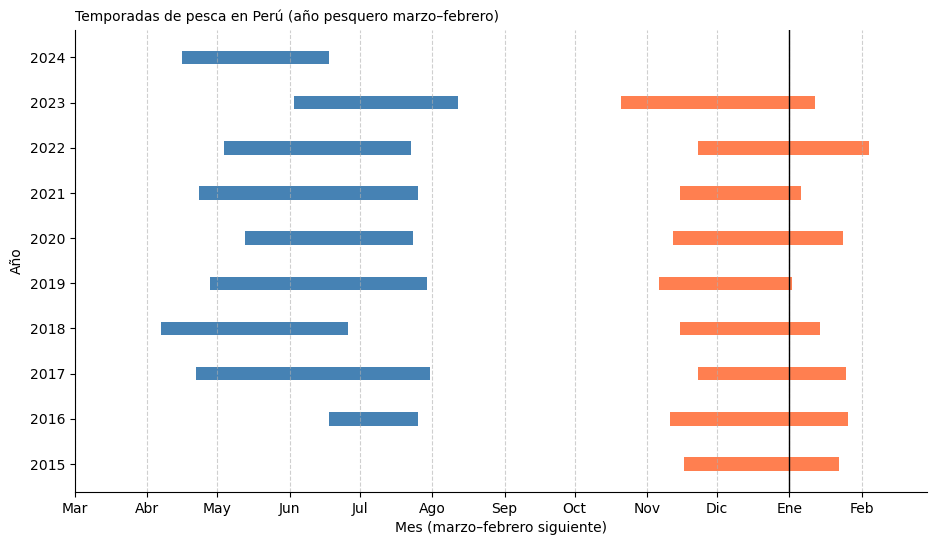

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_fechas_temporada.copy()
df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'])
df['fecha_fin'] = pd.to_datetime(df['fecha_fin'])
df = df.reset_index().rename(columns={'index': 'temporada'})

df['anio'] = df['temporada'].str.extract(r'(\d{4})').astype(int)
df['tipo'] = df['temporada'].str.extract(r'(1ra|2da)')

# Año pesquero: marzo → febrero siguiente
def dia_pesquero(fecha):
    ref = pd.Timestamp(year=fecha.year, month=3, day=1)
    if fecha >= ref:
        return (fecha - ref).days
    else:
        ref_prev = pd.Timestamp(year=fecha.year - 1, month=3, day=1)
        return (fecha - ref_prev).days

df['inicio_dia'] = df['fecha_inicio'].apply(dia_pesquero)
df['fin_dia'] = df['fecha_fin'].apply(dia_pesquero)

mask = df['fin_dia'] < df['inicio_dia']
df.loc[mask, 'fin_dia'] += 365

fig, ax = plt.subplots(figsize=(11,6))
colores = {'1ra': 'steelblue', '2da': 'coral'}

for _, row in df.iterrows():
    y = row['anio']
    ax.barh(
        y=y,
        width=row['fin_dia'] - row['inicio_dia'],
        left=row['inicio_dia'],
        color=colores[row['tipo']],
        height=0.3
    )

meses = ['Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic', 'Ene', 'Feb']
dias_mes = [0, 31, 61, 92, 122, 153, 184, 214, 245, 275, 306, 337]
ax.set_xticks(dias_mes)
ax.set_xticklabels(meses)

ax.set_xlim(0, 365)
ax.set_yticks(sorted(df['anio'].unique()))
ax.set_yticklabels(sorted(df['anio'].unique()))
ax.set_xlabel('Mes (marzo–febrero siguiente)')
ax.set_ylabel('Año')
ax.set_title('Temporadas de pesca en Perú (año pesquero marzo–febrero)', loc='left', fontsize=10)
ax.grid(axis='x', linestyle='--', alpha=0.6)
ax.axvline(x=306, color='black', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend(handles=[plt.Line2D([0], [0], color='steelblue', lw=6, label='1ra temporada'),
#                    plt.Line2D([0], [0], color='coral', lw=6, label='2da temporada')],
#                      loc='upper right', frameon=False)



In [ ]:
df_calas['fecha_cala'] = pd.to_datetime(df_calas['fecha_cala'], errors='coerce').dt.tz_localize('America/Lima')
serie_diaria = df_calas.groupby('fecha_cala')['declarado_tm'].sum().rename('total_pescado_tm').reset_index()
serie_diaria = serie_diaria.set_index('fecha_cala').sort_index().asfreq('D')

serie_diaria['anio'] = serie_diaria.index.year
serie_diaria['dia_del_anio'] = serie_diaria.index.dayofyear
serie_diaria['semana'] = ((serie_diaria['dia_del_anio'] - 1) // 7) + 1

serie_semanal = serie_diaria.groupby(['anio', 'semana'])['total_pescado_tm'].sum().reset_index()
serie_semanal['fecha_semana'] = pd.to_datetime(serie_semanal['anio'].astype(str)) + pd.to_timedelta((serie_semanal['semana'] - 1) * 7, unit='D')

serie_diaria['bloque3d'] = ((serie_diaria['dia_del_anio'] - 1) // 3) + 1

serie_3dias = serie_diaria.groupby(['anio', 'bloque3d'])['total_pescado_tm'].sum().reset_index()
serie_3dias['fecha_bloque'] = pd.to_datetime(serie_3dias['anio'].astype(str)) + pd.to_timedelta((serie_3dias['bloque3d'] - 1) * 3, unit='D')


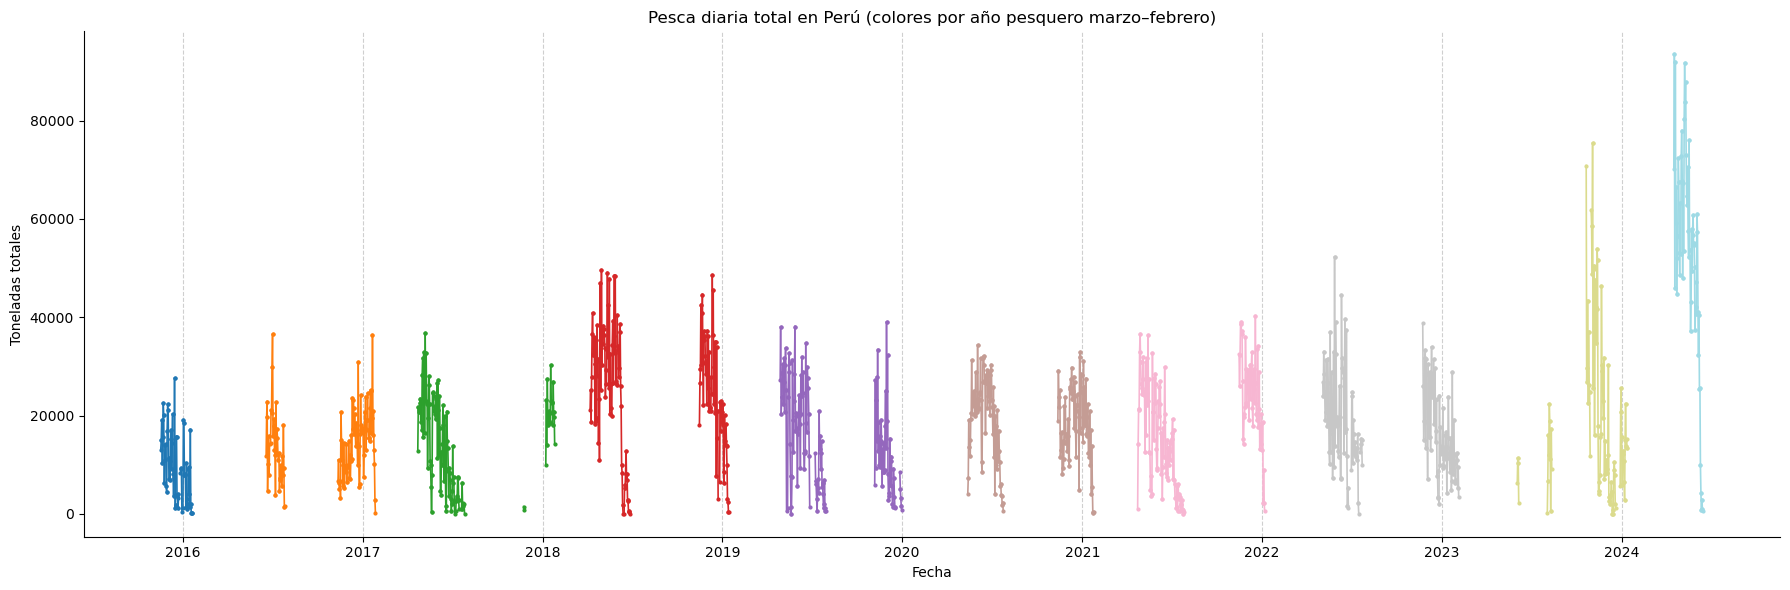

In [18]:

fig, ax = plt.subplots(figsize=(18,6))

def anio_pesquero(ts):
    return ts.year if ts.month >= 3 else ts.year - 1

df_plot = serie_diaria.reset_index().copy()
df_plot['anio_pesquero'] = df_plot['fecha_cala'].apply(anio_pesquero)

aps = sorted(df_plot['anio_pesquero'].unique())
base_cmap = plt.colormaps.get_cmap('tab20')
colors = [base_cmap(i / max(1, len(aps) - 1)) for i in range(len(aps))]
color_map = {ap: colors[i] for i, ap in enumerate(aps)}

plotted = set()
for ap, df in df_plot.groupby('anio_pesquero'):
    df = df.sort_values('fecha_cala')
    x = df['fecha_cala'].values
    y = df['total_pescado_tm'].values
    mask = y > 0
    for i in range(1, len(y)):
        if mask[i-1] and mask[i]:
            ax.plot(
                x[i-1:i+1], y[i-1:i+1],
                lw=1.2, color=color_map[ap],
                marker='o', markersize=2,
                label=(ap if ap not in plotted else None)
            )
    plotted.add(ap)

ax.set_xlabel('Fecha')
ax.set_ylabel('Toneladas totales')
ax.set_title('Pesca diaria total en Perú (colores por año pesquero marzo–febrero)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

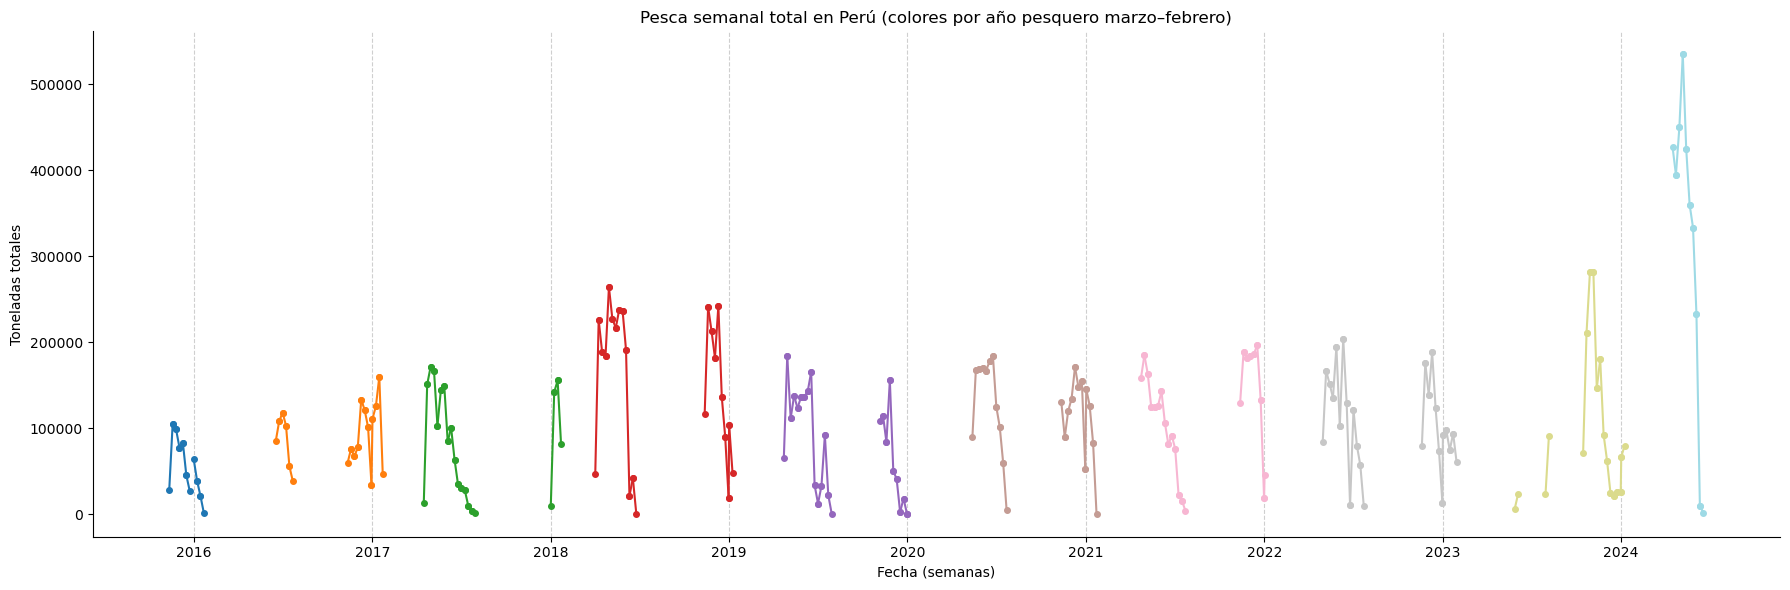

In [ ]:



fig, ax = plt.subplots(figsize=(18,6))

def anio_pesquero(ts):
    return ts.year if ts.month >= 3 else ts.year - 1

df_plot = serie_semanal.sort_values('fecha_semana').copy()
df_plot['anio_pesquero'] = df_plot['fecha_semana'].apply(anio_pesquero)

aps = sorted(df_plot['anio_pesquero'].unique())
base_cmap = plt.colormaps.get_cmap('tab20')
colors = [base_cmap(i / max(1, len(aps) - 1)) for i in range(len(aps))]
color_map = {ap: colors[i] for i, ap in enumerate(aps)}

plotted = set()
for ap, df in df_plot.groupby('anio_pesquero'):
    df = df.sort_values('fecha_semana')
    x = df['fecha_semana'].values
    y = df['total_pescado_tm'].values
    mask = y > 0
    for i in range(1, len(y)):
        if mask[i-1] and mask[i]:
            ax.plot(x[i-1:i+1], y[i-1:i+1], lw=1.5, color=color_map[ap], marker='o', markersize=4,
                    label=(ap if ap not in plotted else None))
    plotted.add(ap)

ax.set_xlabel('Fecha (semanas)')
ax.set_ylabel('Toneladas totales')
ax.set_title('Pesca semanal total en Perú (colores por año pesquero marzo–febrero)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


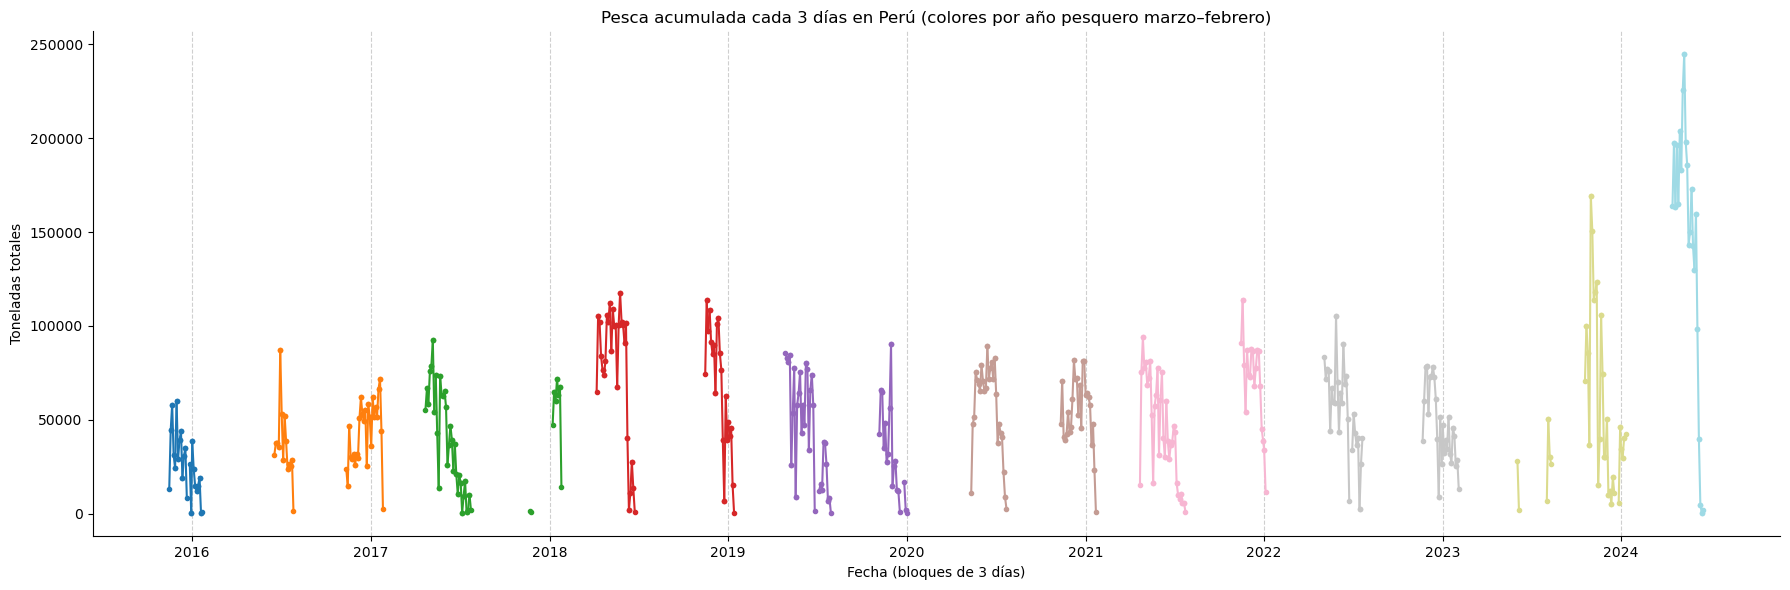

In [ ]:

fig, ax = plt.subplots(figsize=(18,6))

def anio_pesquero(ts):
    return ts.year if ts.month >= 3 else ts.year - 1

df_plot = serie_3dias.sort_values('fecha_bloque').copy()
df_plot['anio_pesquero'] = df_plot['fecha_bloque'].apply(anio_pesquero)

aps = sorted(df_plot['anio_pesquero'].unique())
base_cmap = plt.colormaps.get_cmap('tab20')
colors = [base_cmap(i / max(1, len(aps) - 1)) for i in range(len(aps))]
color_map = {ap: colors[i] for i, ap in enumerate(aps)}

plotted = set()
for ap, df in df_plot.groupby('anio_pesquero'):
    df = df.sort_values('fecha_bloque')
    x = df['fecha_bloque'].values
    y = df['total_pescado_tm'].values
    mask = y > 0
    for i in range(1, len(y)):
        if mask[i-1] and mask[i]:
            ax.plot(x[i-1:i+1], y[i-1:i+1], lw=1.5, color=color_map[ap],
                    marker='o', markersize=3,
                    label=(ap if ap not in plotted else None))
    plotted.add(ap)

ax.set_xlabel('Fecha (bloques de 3 días)')
ax.set_ylabel('Toneladas totales')
ax.set_title('Pesca acumulada cada 3 días en Perú (colores por año pesquero marzo–febrero)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
